In [52]:
%reset -f
%load_ext autoreload
%autoreload 2

import os
import time
import numpy as np
# import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import dill as pickle
import figurefirst as fifi
from pybounds import colorline
import figure_functions as ff
import util
from trajectory_animator import TrajectoryAnimator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load trajectory data

In [53]:
data_root  = os.path.join(os.path.pardir, 'data', 'simulated')

In [54]:
file_names = ['custom_trajectory.pk']

In [55]:
data_list = []
for f in file_names:
    data_path = os.path.join(data_root, f)
    with open(data_path, 'rb') as handle:
        datain = pickle.load(handle)
        data_list.append(datain)

print(datain.keys())

dict_keys(['data'])


In [56]:
n_file = len(data_list)

In [57]:
data_dict = data_list[0]['data'][0]
data_dict.keys()

dict_keys(['states', 'sensors', 'time_steps', 'sim_data', 'error_variance', 'O_sliding'])

In [58]:
states = [['x', 'y', 'z',
           'g', 'beta', 'v_z',
           'phi', 'theta', 'psi',
           'omega_x', 'omega_y', 'omega_z',
           'w', 'zeta',
           'm', 'I_x', 'I_y', 'I_z', 'C']
          ]

sensors = [['psi', 'gamma', 'beta'],
           ['psi', 'gamma', 'beta', 'r'],
           ['psi', 'gamma', 'beta', 'a'],
           ['psi', 'gamma', 'beta', 'r', 'a'],
           ['psi', 'gamma', 'beta', 'a', 'g']
           ]

time_steps = [5]

In [59]:
index_map, n_sensors, n_states, n_time_steps = util.get_indices(data_dict,
                                                                states_list=states,
                                                                sensors_list=sensors,
                                                                time_steps_list=time_steps)

# Plot

In [60]:
plot_var = ('zeta', 'w', 'g', 'z')
n_plot_var = len(plot_var)

In [61]:
time_window = (0.9, 11.0)

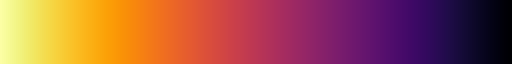

In [62]:
# cmap = ff.Colormaps(color_dict='purple_green_gray', power=3, flip_linear=False, flip_log=True)
cmap = ff.Colormaps(color_dict='inferno', power=1, flip_linear=True, flip_log=True)

# cmap.log[plot_var[0]]

cmap = plt.colormaps['inferno_r']
cmap

In [63]:
# Set color normalization
log_tick_low = -3
log_tick_high = 6
log_ticks = np.logspace(log_tick_low, log_tick_high, log_tick_high - log_tick_low + 1)
cnorm = mpl.colors.LogNorm(10 ** log_tick_low, 10 ** log_tick_high)

In [64]:
LatexConverter = ff.LatexStates()

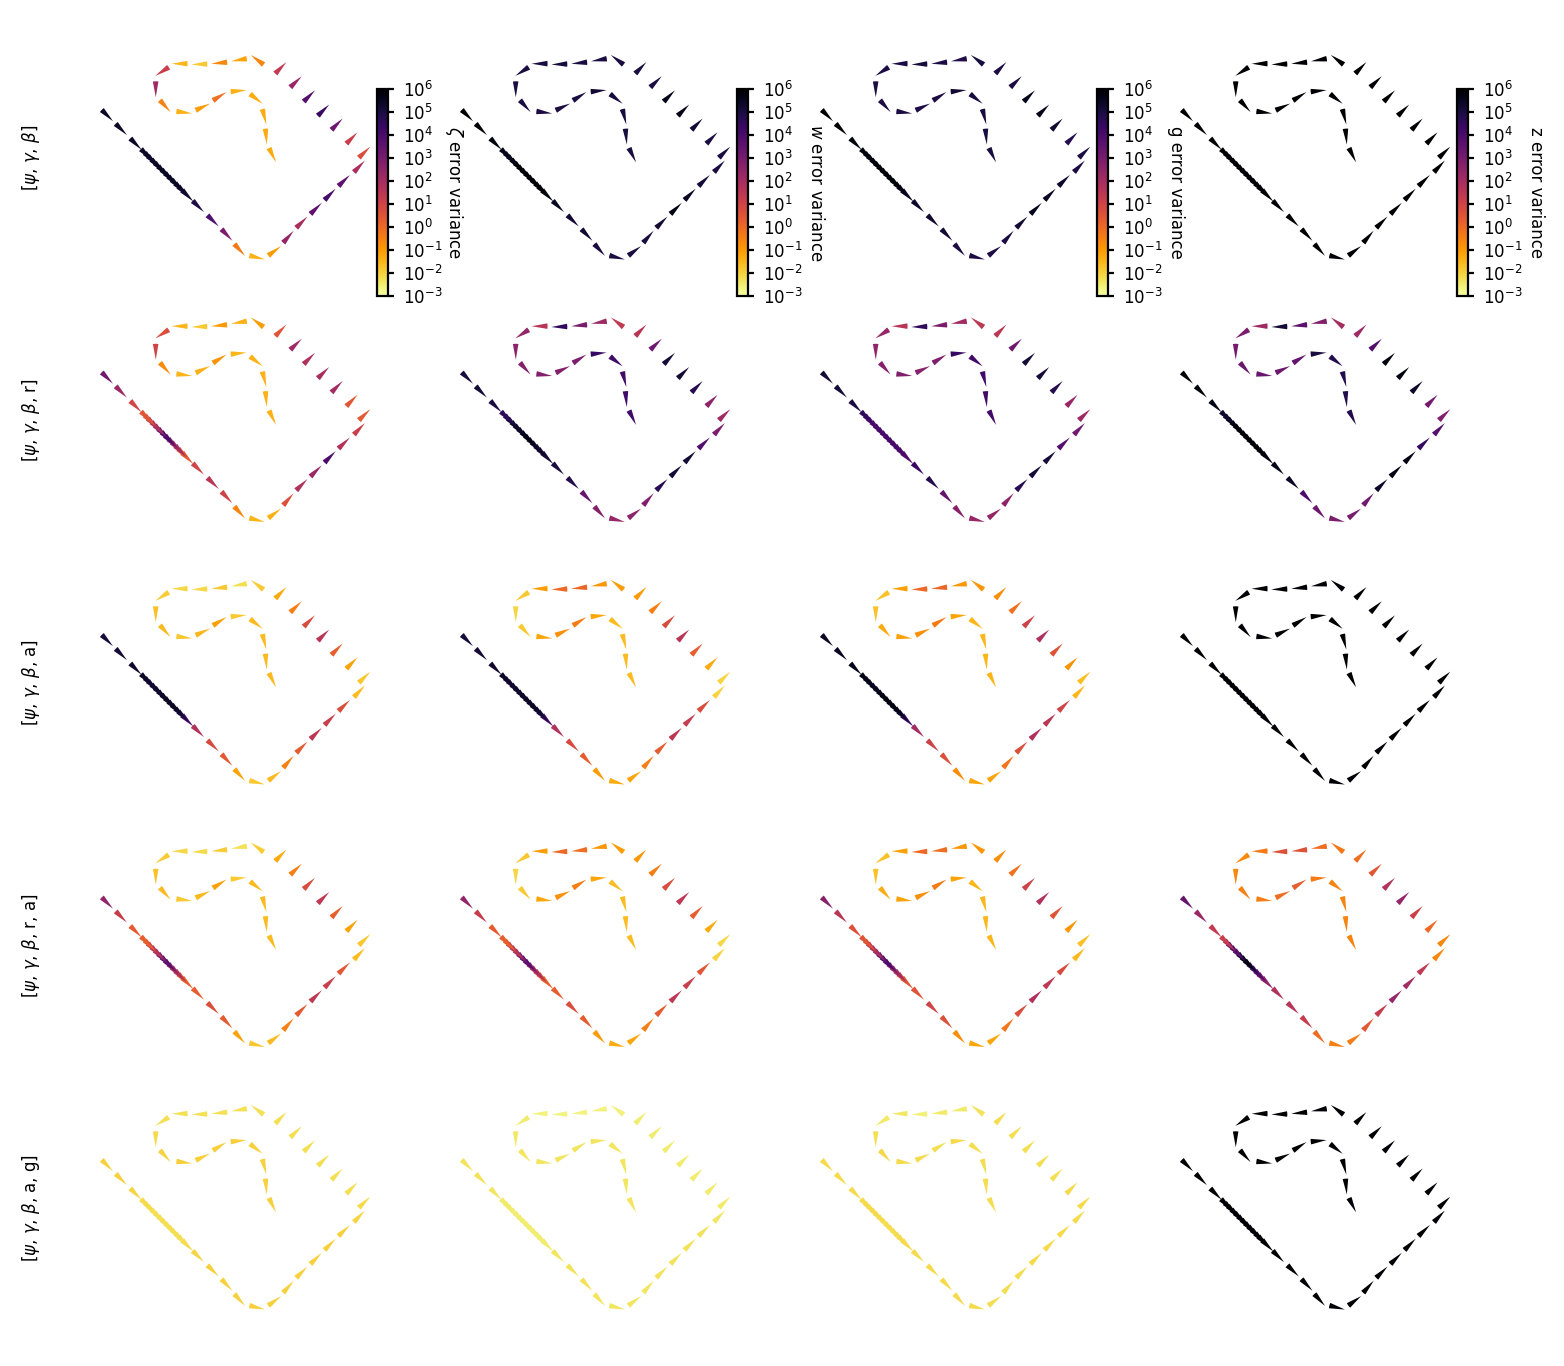

In [65]:
fig, ax = plt.subplots(nrows=n_sensors, ncols=n_plot_var, sharex=True, sharey=True,
                       figsize=(2.0*n_plot_var, 2.0*n_sensors), dpi=200)

data = data_dict
for p in range(n_sensors):
    ax[p, 0].set_ylabel('[' + ', '.join(LatexConverter.convert_to_latex(sensors[p])) + ']', fontsize=6)
    j = index_map[p, 0, 0]
    sim_data = data['sim_data'][j]
    sim_data = sim_data.fillna(method='bfill').fillna(method='ffill')

    time = sim_data['time'].values
    t_start = np.where((time >= time_window[0]))[0][0]
    t_end = np.where((time <= time_window[1]))[0][-1]
    sim_data = sim_data.iloc[t_start:t_end, :]
    x = sim_data['x'].values
    y = sim_data['y'].values
    psi = sim_data['psi'].values

    for v in range(n_plot_var):
        ev = sim_data['o_' + plot_var[v]].values

        # Plot
        ff.plot_trajectory(x, y, psi,
                           color=ev,
                           ax=ax[p, v],
                           size_radius=0.16,
                           nskip=1,
                           colormap=cmap,
                           colornorm=cnorm)

        if p == 0:
            # Colorbar
            cax = ax[p, v].inset_axes([0.9, 0.0, 0.03, 0.75])
            cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax, ticks=log_ticks)
            cbar.set_label(LatexConverter.convert_to_latex(plot_var[v]) + ' error variance',
                           rotation=270, fontsize=6, labelpad=8)
            cbar.ax.tick_params(labelsize=6, length=2)

for a in ax.flat:
    a.set_facecolor((1.0, 1.0, 1.0, 0.0))
    a.set_aspect(1.0)
    # a.set_xlim(-.05, 3.5 + 1.6*n_plot_var)
    # a.set_ylim(-0.05, 2.5)
    a.tick_params(axis='both', which='major', labelsize=6, bottom=False, labelbottom=False, left=False, labelleft=False)
    for s in ['top', 'bottom', 'left', 'right']:
        a.spines[s].set_visible(False)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=-0.65, wspace=-0.0)

fig_path = os.path.join(os.pardir, 'fig', 'custom_trajectory.pdf')
plt.savefig(fig_path, bbox_inches='tight')

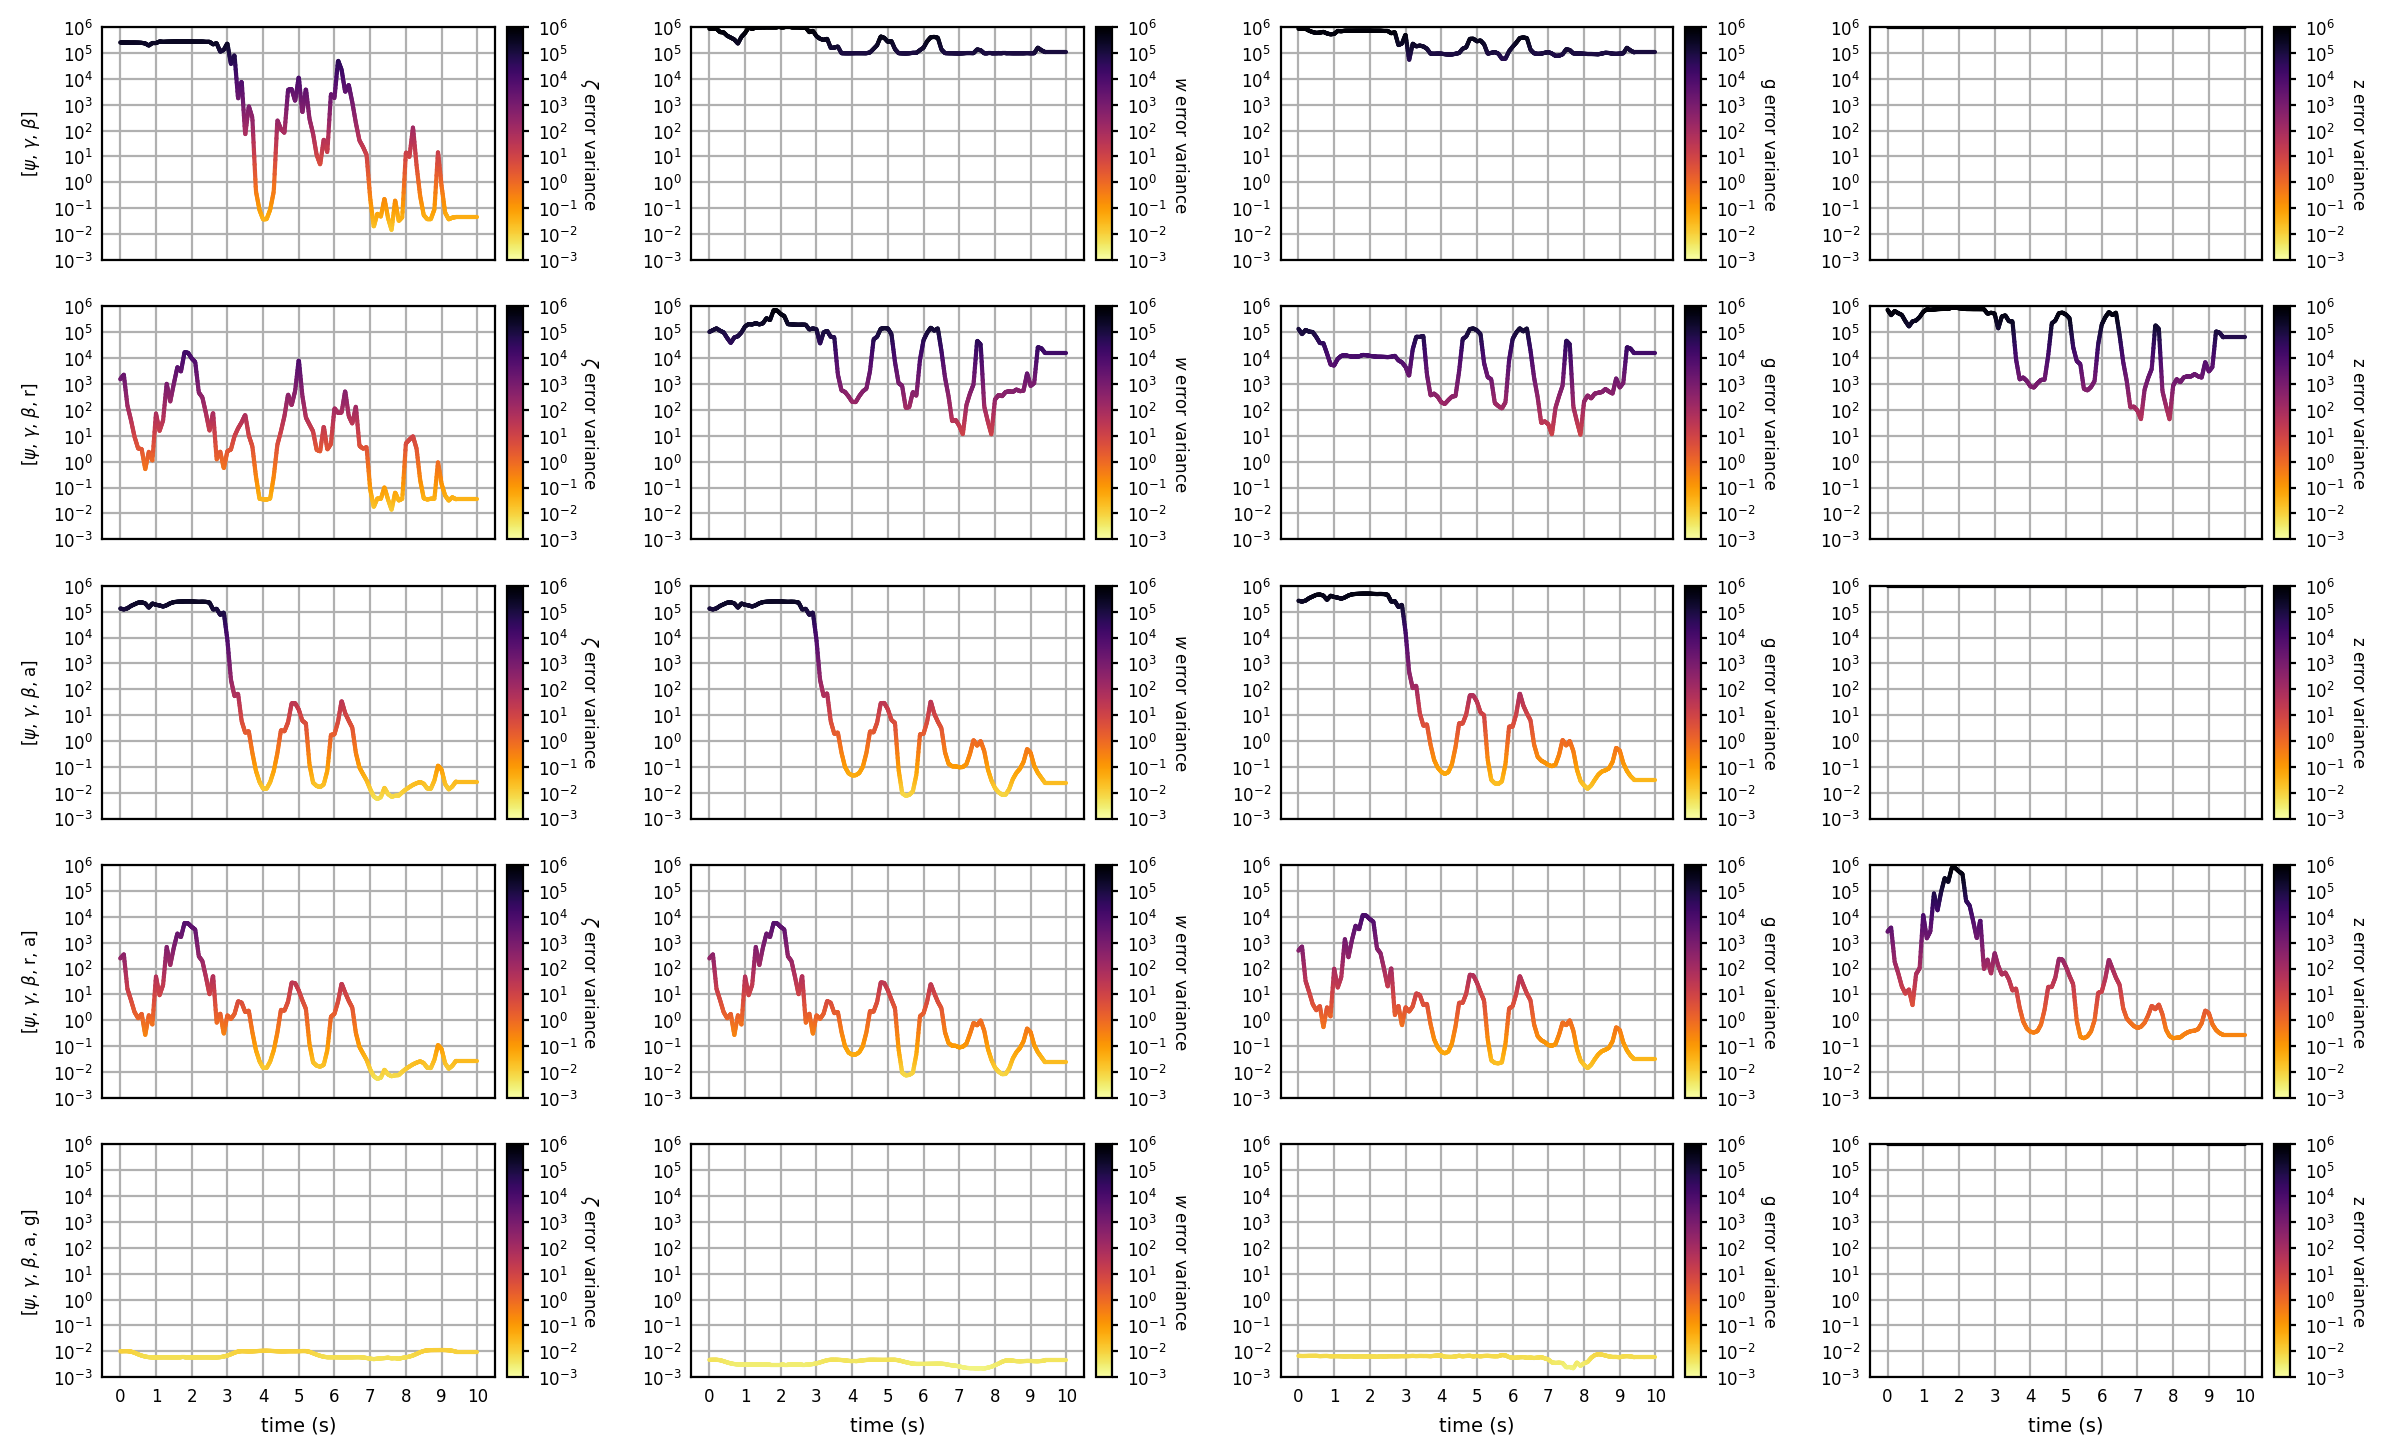

In [66]:
fig, ax = plt.subplots(nrows=n_sensors, ncols=n_plot_var, sharex=False, sharey=True,
                       figsize=(3.0*n_plot_var, 1.5*n_sensors), dpi=200)

data = data_dict
for p in range(n_sensors):
    ax[p, 0].set_ylabel('[' + ', '.join(LatexConverter.convert_to_latex(sensors[p])) + ']', fontsize=6)
    j = index_map[p, 0, 0]
    sim_data = data['sim_data'][j]
    sim_data = sim_data.fillna(method='bfill').fillna(method='ffill')

    time = sim_data['time'].values
    t_start = np.where((time >= time_window[0]))[0][0]
    t_end = np.where((time <= time_window[1]))[0][-1]
    sim_data = sim_data.iloc[t_start:t_end, :]
    x = sim_data['x'].values
    y = sim_data['y'].values
    psi = sim_data['psi'].values
    time = sim_data['time'].values
    time= time - time[0]

    for v in range(n_plot_var):
        ev = sim_data['o_' + plot_var[v]].values

        # # Colorline: log
        f = util.log_interpolator(time, ev, kind='slinear')
        tsim_interp = np.linspace(time[0], time[-1], 1000)
        ev_interp = f(tsim_interp)
        tsim_norm = np.linspace(tsim_interp[0], tsim_interp[-1], tsim_interp.shape[0])

        colorline(tsim_norm, ev_interp, ev_interp,
                  ax=ax[p, v], cmap=cmap, norm=cnorm, linewidth=1.5)

        # ax[p, v].plot(time, ev)

        # Colorbar
        cax = ax[p, v].inset_axes([1.03, 0.0, 0.04, 1.0])
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax, ticks=log_ticks)
        cbar.set_label(LatexConverter.convert_to_latex(plot_var[v]) + ' error variance',
                       rotation=270, fontsize=6, labelpad=8)
        cbar.ax.tick_params(labelsize=6, length=2)

for a in ax.flat:
    a.set_facecolor((1.0, 1.0, 1.0, 0.0))
    a.set_yscale('log')
    a.set_yticks(log_ticks)
    a.set_ylim(log_ticks[0], log_ticks[-1])
    a.set_xticks(np.arange(0.0, time[-1] + 1e-3, step=1.0))
    a.set_xlim(time[0] - 0.5, time[-1] + 0.5)
    a.grid()
    a.tick_params(axis='both', which='major', length=0, labelsize=6, bottom=True, labelbottom=True, left=True, labelleft=True)
    a.minorticks_off()
    # for s in ['top', 'bottom', 'left', 'right']:
    #     a.spines[s].set_visible(False)

for a in ax[0:-1, :].flat:
    a.set_xticklabels([])

for a in ax[-1, :].flat:
    a.set_xlabel('time (s)', fontsize=7)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.2, wspace=0.5)

fig_path = os.path.join(os.pardir, 'fig', 'custom_trajectory_error_variance.pdf')
plt.savefig(fig_path, bbox_inches='tight')

# Plot time-series as heatmap

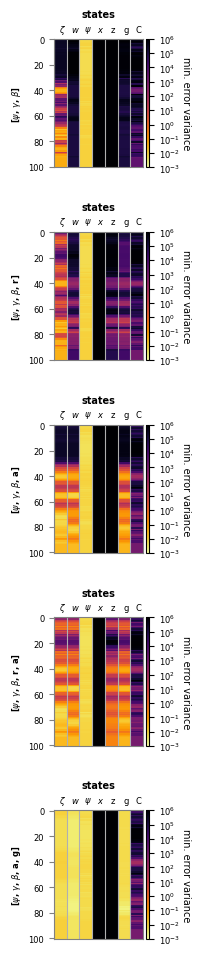

In [67]:
fig, ax = plt.subplots(nrows=n_sensors, ncols=1, figsize=(4 * 1, n_sensors * 2),
                       sharex=True, sharey=True, dpi=100)


for p in range(n_sensors):
    j = index_map[p, 0, 0]
    error_variance = data['error_variance'][j]
    error_variance = error_variance.fillna(method='bfill').fillna(method='ffill')

    time = error_variance['time'].values
    t_start = np.where((time >= time_window[0]))[0][0]
    t_end = np.where((time <= time_window[1]))[0][-1]
    error_variance = error_variance.iloc[t_start:t_end, :]
    heatmap = error_variance.iloc[0:, 2:]
    heatmap = heatmap.loc[:, ['zeta', 'w',
                              'psi',
                              'x', 'z',
                              'g', 'C']]

    labels = list(heatmap.columns)

    # Plot
    cnorm, cmap, log_ticks = ff.plot_heatmap_log_timeseries(heatmap.values, ax=ax[p],
                                                            data_labels=labels,
                                                            aspect=0.1,
                                                            log_ticks=(-3, 6),
                                                            y_label='min. error variance',
                                                            interpolation=False)

    ax[p].set_ylabel('[' + ', '.join(LatexConverter.convert_to_latex(sensors[p])) + ']', fontsize=6)

fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.5, wspace=0.5)
fig_path = os.path.join(os.pardir, 'fig', 'custom_trajectory_error_variance_heatmap.pdf')
plt.savefig(fig_path, bbox_inches='tight')

# Plot time trajectory

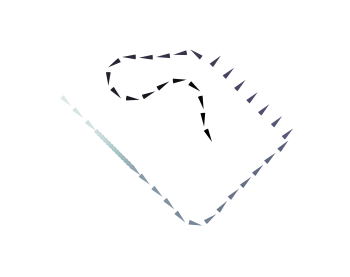

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(2 * 1, 2 * 1), sharex=True, sharey=True, dpi=200)

cmap_time = mpl.colors.ListedColormap(plt.colormaps['bone_r'](np.linspace(0.1, 1.0, num=100)))
ff.plot_trajectory(sim_data['x'].values, sim_data['y'].values, sim_data['psi'].values,
                   color=sim_data['time'].values,
                   ax=ax,
                   size_radius=0.16,
                   nskip=1,
                   colormap=cmap_time)

fifi.mpl_functions.adjust_spines(ax, [])

# Animate

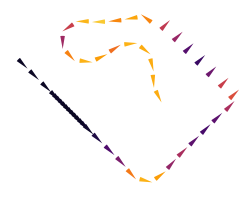

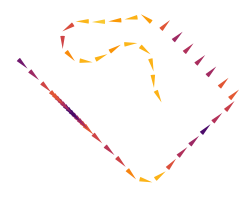

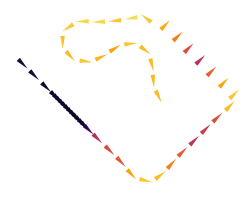

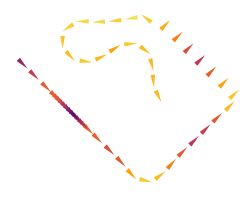

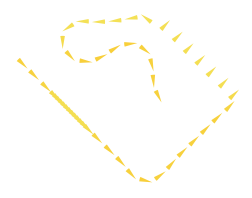

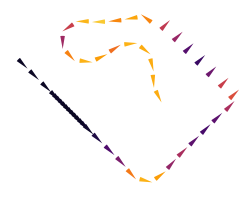

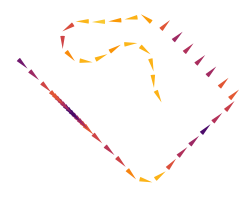

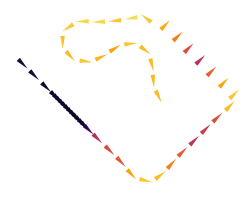

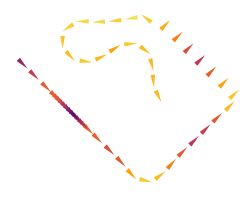

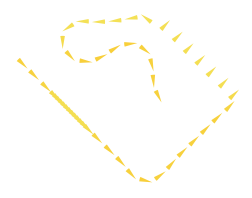

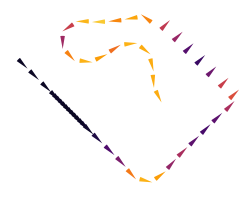

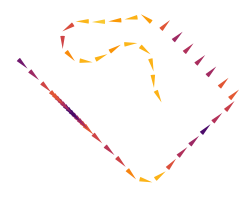

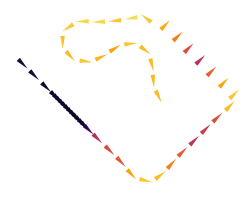

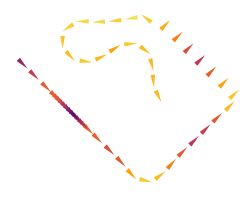

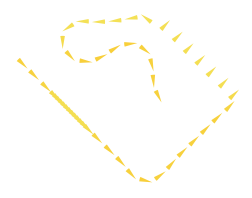

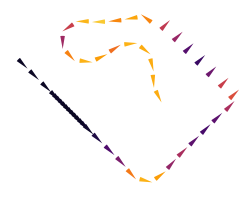

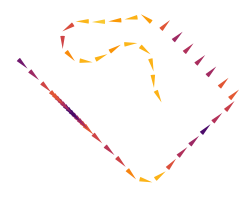

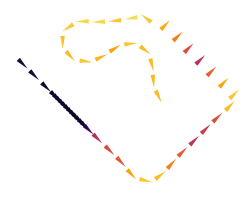

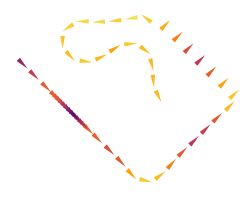

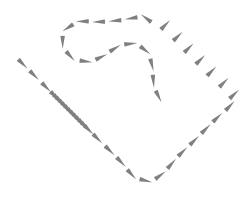

In [69]:
o_vars = plot_var
for v in plot_var:
    for p in range(n_sensors):
        # Get data
        j = index_map[p, 0, 0]
        sim_data = data['sim_data'][j]
        sim_data = sim_data.fillna(method='bfill').fillna(method='ffill')

        time = sim_data['time'].values
        t_start = np.where((time >= time_window[0]))[0][0]
        t_end = np.where((time <= time_window[1]))[0][-1]
        sim_data = sim_data.iloc[t_start:t_end, :]

        # Make animation
        animator = TrajectoryAnimator(x=sim_data['x'].values,
                                      y=sim_data['y'].values,
                                      heading=sim_data['psi'].values,
                                      color=sim_data['o_zeta'].values,
                                      n_skip=2,
                                      colormap='inferno_r',
                                      colornorm=cnorm,
                                      arrow_size=0.16,
                                      sliding_window=5,
                                      fig_kwargs=dict(figsize=(3.0, 3.0),
                                                      dpi=100))

        # Set path
        sensor_label = '_'.join(map(str, sensors[p]))
        animation_path = os.path.join(os.path.pardir, 'animation', file_names[0][0:-3] + '_var=' + v + '_sensors=' + sensor_label + '.mp4')

        # Save
        animator.animation.save(animation_path, fps=10, dpi=300, bitrate=3000, extra_args=['-vcodec', 'mpeg4'])